- Xray energy is from 30-200 Kev (Ref. Method for filling and sharpening false color layers of dual energy x-ray images)

- $Q = \frac{logI_{LE}}{logI_{HE}}$
1. Metal 1.02 - 1.15
2. Plastic 1.005 - 1.02
3. Organic 0972 - 1.005

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append("../")

In [3]:
from glob import glob
import numpy as np
from color_image import ColorImage
from xraydb import material_mu
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image as Im

In [4]:
def get_voxels(stl_file, voxel_resolution = 300, rotation = 180):
    ci = ColorImage(stl_file, voxel_resolution=voxel_resolution)
    ci.rotate([0.5, 0, 0], rotation)
    ci.generate_voxels()
    return ci.voxels

def get_image(stl_file, voxel_resolution = 300, rotation = 180, axis = 2):
    return np.sum(ci.voxels, axis=axis)

In [5]:
def plot_data(data, cmap = 'GnBu'):
    plt.figure(figsize=(15, 10))
    im = plt.imshow(data, cmap=cmap)
    plt.axis('off')
    plt.show()

In [6]:
def subplot(data, cmap = "GnBu_r"):
    fig, axs = plt.subplots(3, figsize = (15, 15))
    axs[0].imshow(data[0], cmap = cmap)
    axs[0].axis('off')
    axs[1].imshow(data[1], cmap = cmap)
    axs[1].axis('off')
    axs[2].imshow(data[2], cmap = cmap)
    axs[2].axis('off')
    plt.show()

In [7]:
def get_xray_image(energy = 1e5):
    thickness_factor = 10
    l1_width = np.sum(stack_handgun, axis = 2) / thickness_factor
    l1_xray = np.ones_like(l1_width)
    m1 = material_mu('Fe', energy)
    l2_xray = np.multiply(l1_xray, np.exp(-m1 * l1_width))

    l2_width = np.sum(stack_knife, axis = 2) / thickness_factor
    m2 = material_mu('Al', energy)
    l3_xray = np.multiply(l2_xray, np.exp(-m2 * l2_width))

    l3_width = np.sum(stack_mouse, axis = 2) / thickness_factor
    m3 = material_mu('C', energy)
    l4_xray = np.multiply(l3_xray, np.exp(-m3 * l3_width))
    
    return l4_xray
#     return np.log(np.true_divide(l4_xray, l1_xray)), l4_xray 

In [8]:
# door_handle, handgun, knife, mouse, shuriken
thickness_factor = 10.0
stl_files = "../stl_files/"
voxels = get_voxels(stl_files + "handgun_knife_mouse.stl")

In [9]:
# Get the layers for each object
# TODO: Write code for identifying voxels for each object
stack = voxels.astype(np.float32)
stack_handgun = stack[..., :30]
stack_knife = stack[..., 30:64]
stack_mouse = stack[..., 64:]

# Helix Pseudocolor Algorithm

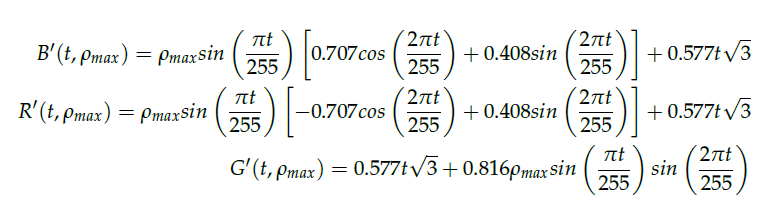

In [10]:
from IPython.display import Image
Image("images/HPC_equations.png")

Where 
- $t$ = Brightness [0, 255] and 
-images$o_{max}$ = Color saturation [0, 140] (0 gives grayscale values, 140 is the most saturateed color and the recommended value)

In [11]:
def hpc(img, rho):
    assert len(img.shape) == 2
    img = np.array(img)
    blue = rho * np.sin(np.pi * img / 255.) * (0.707 * np.cos(2 * np.pi * img / 255.) + 0.408 * np.sin(2 * np.pi * img / 255.)) + 0.577 * img * np.sqrt(3)
    red = rho * np.sin(np.pi * img / 255.) * ( - 0.707 * np.cos(2 * np.pi * img / 255.) + 0.408 * np.sin(2 * np.pi * img / 255.)) + 0.577 * img * np.sqrt(3)
    green = 0.577 * img * np.sqrt(3) + 0.816 * rho * np.sin(np.pi * img / 255.) * np.sin(2 * np.pi * img / 255.)
    rgb =  np.dstack((red, green, blue))
    return np.array(rgb / rgb.max() * 255, dtype = np.uint8)

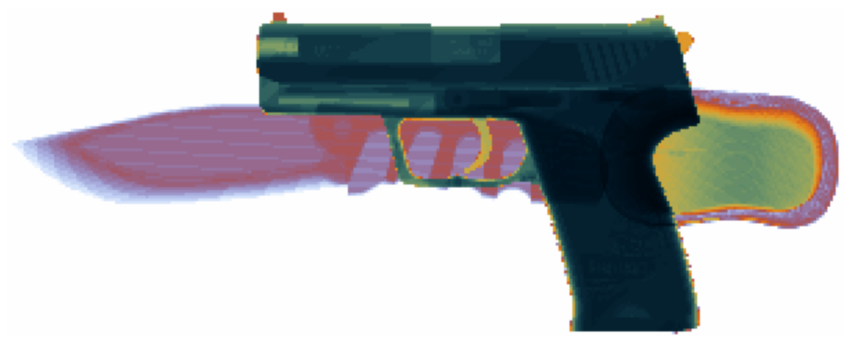

In [12]:
# xray_gray = np.sum(me, axis = 2)
xray_gray = get_xray_image(energy = 2e5)
xray_gray = np.array(xray_gray / xray_gray.max() * 255, dtype = np.uint8)

plot_data(hpc(xray_gray, 140))

# Linear Mapping

- Reference: Abidi, B. R., Zheng, Y., Gribok, A. V., & Abidi, M. A. (2006). Improving weapon detection in single energy X-ray images through pseudocoloring. IEEE Transactions on Systems, Man and Cybernetics Part C: Applications and Reviews, 36(6), 784–796. https://doi.org/10.1109/TSMCC.2005.855523

## a) Hot

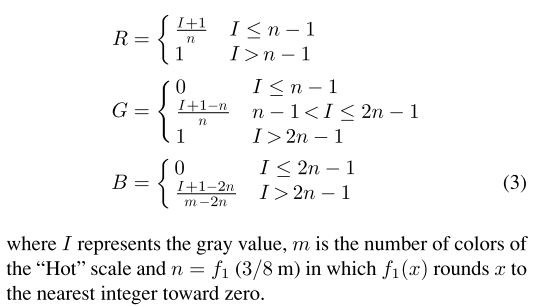

In [13]:
Image("images/linear_mapping_cmap_hot.png")

## b) Jet

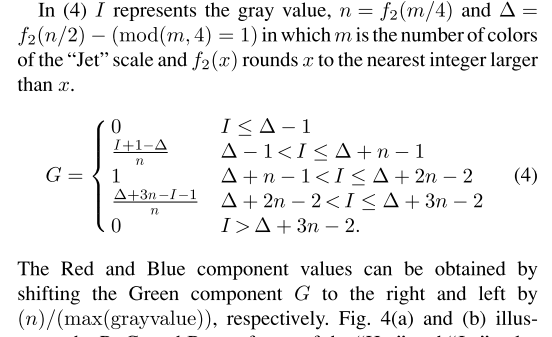

In [14]:
Image("images/linear_mapping_cmap_jet.png")

In [15]:
def linear_mapping(img, m = 8, cmap = 'hot'):
    img = np.array(img)

    if cmap == 'hot':
        n = np.floor(3. / 8. * m)

        red = (img + 1) / n
        red[img > n-1] = 1

        green = (img + 1 - n) / n
        green[img <= n - 1] = 0
        green[img > 2 * n - 1] = 1

        blue = (img + 1 - 2 * n) / (m - 2 * n)
        blue[img <= 2 * n - 1] = 0

        rgb =  np.dstack((red, green, blue))
        return np.array(rgb / rgb.max() * 255, dtype = np.uint8)
    elif cmap == 'jet':
        n = np.ceil(m / 4.)
        delta = np.ceil(n / 2.) - np.mod(m, 4)

        green = np.zeros_like(img)
        green[(delta - 1. < img) & (img <= delta + n - 1)] = (img[(delta - 1. < img) & (img <= delta + n - 1)] + 1. - delta) / n
        green[(delta + n - 1 < img) & (img <= delta + 2.*n -2.)] = 1.
        green[(delta + 2. * n - 2 < img) & (img <= delta + 3. * n -2)] = (delta + 3.*n - img[(delta + 2. * n - 2. < img) & (img <= delta + 3 * n -2)] - 1.) / n

        red = green + (n / img.max())
        blue = green - (n / img.max())

        rgb = np.dstack((red, green, blue))
        return np.array(rgb / rgb.max() * 255., dtype = np.uint8)

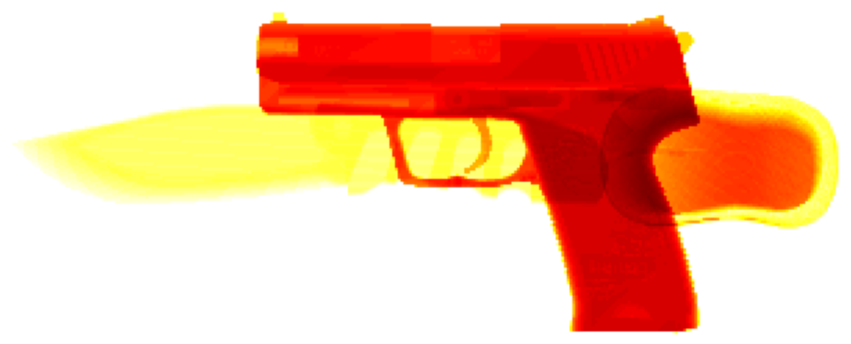

In [16]:
# xray_gray = np.sum(me, axis = 2)
xray_gray = get_xray_image(energy = 8e5)
xray_gray = np.array(xray_gray / xray_gray.max() * 255, dtype = np.float32)

plot_data(linear_mapping(xray_gray, m = 256, cmap = 'hot'))

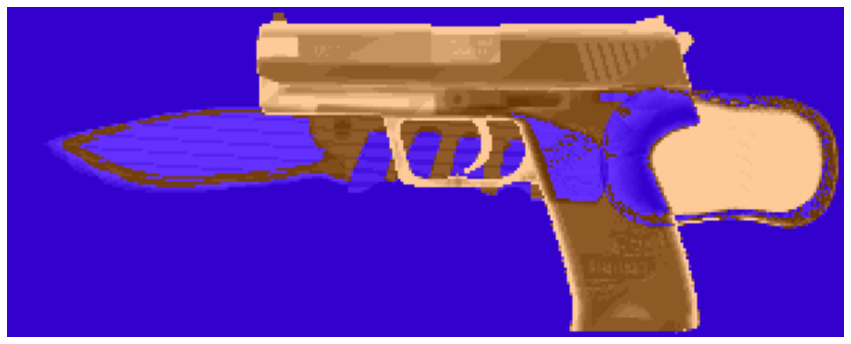

In [17]:
# xray_gray = np.sum(me, axis = 2)
xray_gray = get_xray_image(energy = 5e5)
xray_gray = np.array(xray_gray / xray_gray.max() * 255, dtype = np.float32)

plot_data(linear_mapping(xray_gray, m = 256, cmap = 'jet'))

# Non-linear Mapping
## Springtime

In [18]:
import math

In [19]:
def f1(I,S): # I(1-S)
    return np.multiply(I, np.subtract(1,S))

def f2(I,S,H): # I[1+(ScosH/cos(60-H))]
    r = math.pi/180
    a = np.multiply(S, np.cos(r*H)) # ScosH
    b = np.cos(r*np.subtract(60,H)) # cos(60-H)
    return np.multiply(I, np.add(1, np.divide(a,b)) )

def f3(I,C1,C2): # 3I-(C1+C2)
    return np.subtract(3*I, np.add(C1,C2))

def hsi_to_rgb(H, S, I):
    zmax = 255 # max value

    R,G,B = np.ones(H.shape),np.ones(H.shape),np.ones(H.shape) # values will be between [0,1]
    # for 0 <= H < 120
    B[(0<=H)&(H<120)] = f1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    R[(0<=H)&(H<120)] = f2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    G[(0<=H)&(H<120)] = f3(I[(0<=H)&(H<120)], R[(0<=H)&(H<120)], B[(0<=H)&(H<120)])

    # for 120 <= H < 240
    H = np.subtract(H,120)
    R[(0<=H)&(H<120)] = f1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    G[(0<=H)&(H<120)] = f2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    B[(0<=H)&(H<120)] = f3(I[(0<=H)&(H<120)], R[(0<=H)&(H<120)], G[(0<=H)&(H<120)])

    # for 240 <= H < 360
    H = np.subtract(H,120)
    G[(0<=H)&(H<120)] = f1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    B[(0<=H)&(H<120)] = f2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    R[(0<=H)&(H<120)] = f3(I[(0<=H)&(H<120)], G[(0<=H)&(H<120)], B[(0<=H)&(H<120)])

    rgb = np.dstack( (zmax*R , zmax*G , zmax*B) )
    rgb = np.array(rgb / rgb.max() * 255, np.uint8) # values between [0,255]
    return rgb

In [20]:
def spring_time(img):
    img = np.array(img)
    g_max = 255.
    h = 0.5 - 0.5 * np.sqrt(1 - (img / g_max) ** 2)
    h = h / h.max() * 360
    s = 0.8 * np.ones_like(img, dtype=np.float32)
    i = np.log((img + 1.) / (g_max + 1.))
    
    print(h.max(), s.max(), i.max())
    
    return hsi_to_rgb(h, s, i)

360.0 0.8 0.0


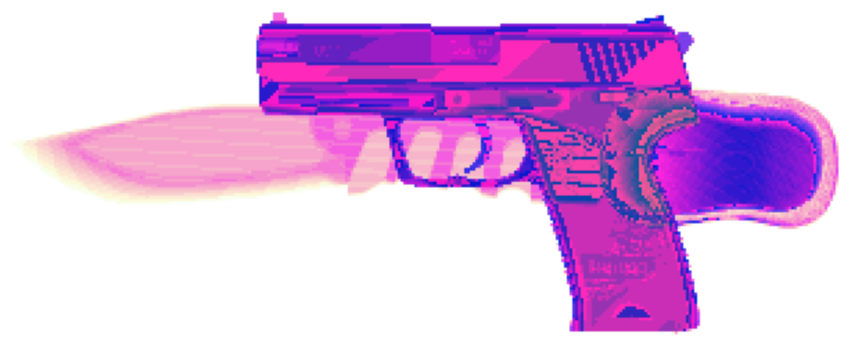

In [21]:
# xray_gray = np.sum(me, axis = 2)
xray_gray = get_xray_image(energy = 5e5)
xray_gray = np.array(xray_gray / xray_gray.max() * 255, dtype = np.float32)

plot_data(spring_time(xray_gray))

### Testing the code with a sample image from sixray dataset

In [22]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [23]:
sample_img = Im.open("images/N0000058.jpg")
sample_img_ar = np.array(sample_img)
sample_gray = rgb2gray(sample_img_ar)

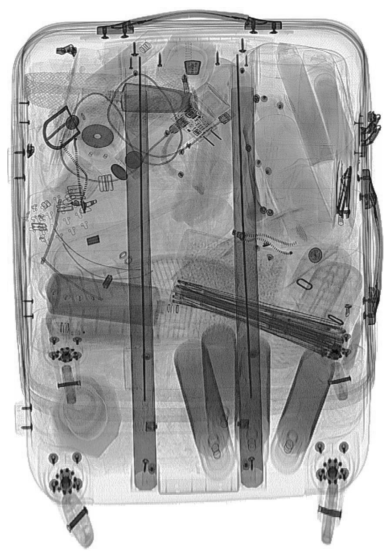

In [24]:
plot_data(sample_gray, cmap = 'gray')

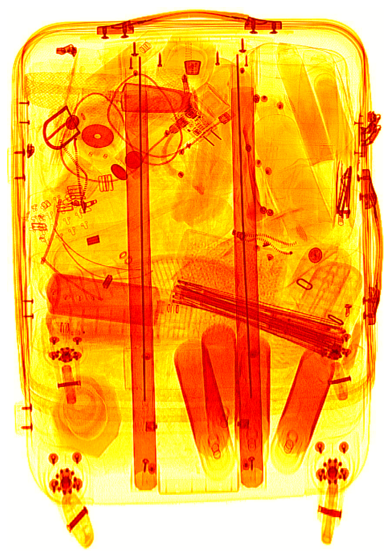

In [25]:
plot_data(linear_mapping(sample_gray, m = 256, cmap = 'hot'))

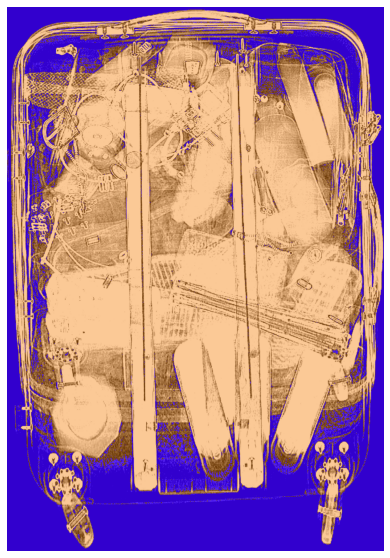

In [26]:
plot_data(linear_mapping(sample_gray, m = 256, cmap = 'jet'))

360.0 0.8 -9.961433634334793e-05


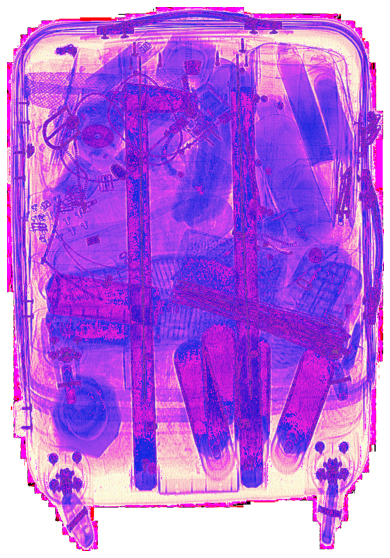

In [27]:
plot_data(spring_time(sample_gray))

# Use dual energy x-ray for false colors

The following method is the same as `get_xray_image` but has cleaner code

In [28]:
def get_xray_image2(energy = 1e5):
    thickness_factor = 10
    m1 = material_mu('Fe', energy)
    m2 = material_mu('Al', energy)
    m3 = material_mu('C', energy)
    l1 = stack_handgun.sum(axis = 2)
    l2 = stack_knife.sum(axis = 2)
    l3 = stack_mouse.sum(axis = 2)
    l0 = np.ones_like(l1, dtype = np.float32)
    exp_factor = m1 * l1 + m2 * l2 + m3 * l3
    
    return np.multiply(l0, np.exp(-exp_factor / thickness_factor))

In [29]:
le = get_xray_image2(energy = 1e5)
me = get_xray_image2(energy = 3e5)
he = get_xray_image2(energy = 5e5)

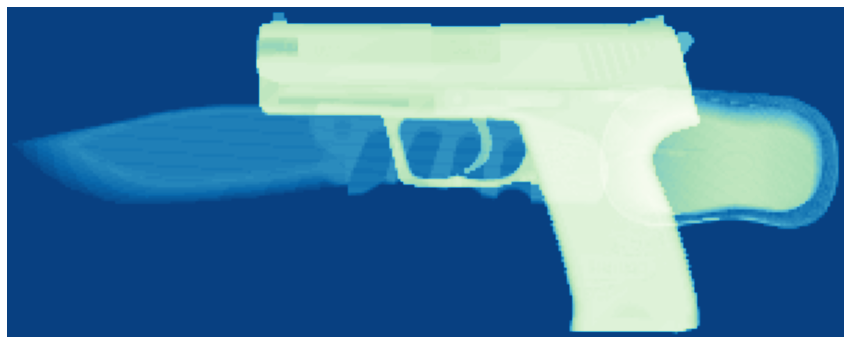

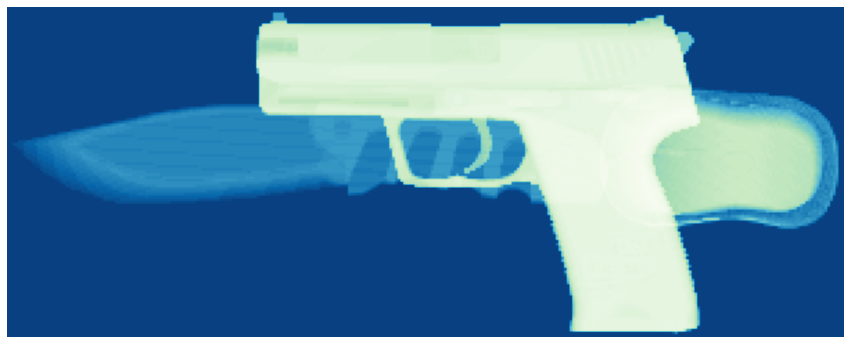

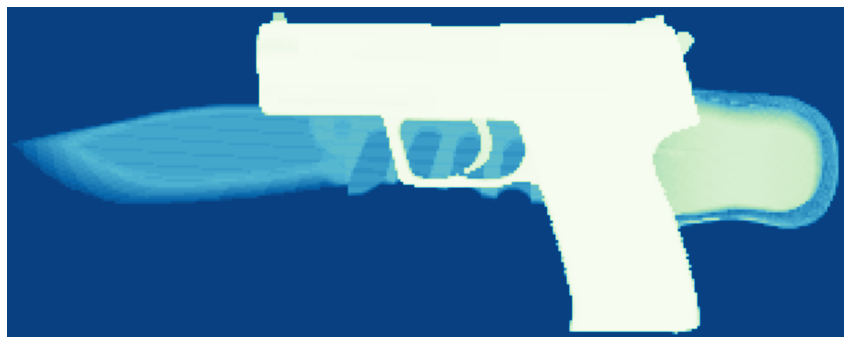

(None, None, None)

In [30]:
plot_data(he), plot_data(me), plot_data(le)

## Using the difference of absoptions

In [32]:
red = np.abs(le - me)
green = np.abs(me - he)
blue = np.abs(he - le)

img_r = np.dstack((red, green, blue))
img_r /= img_r.max()
img_g = np.dstack((green, blue, red))
img_g /= img_g.max()
img_b = np.dstack((blue, red, green))
img_b /= img_b.max()

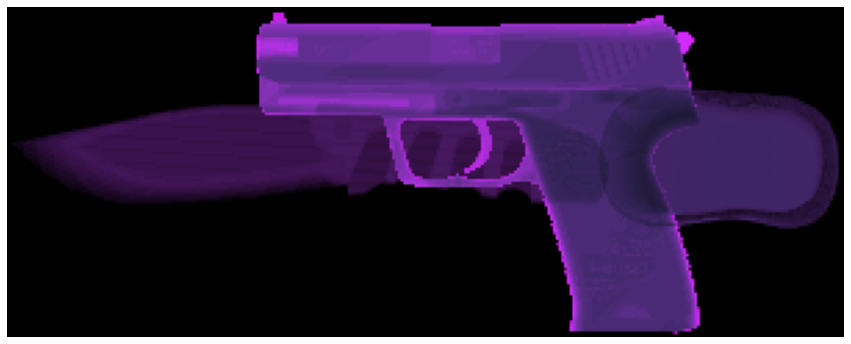

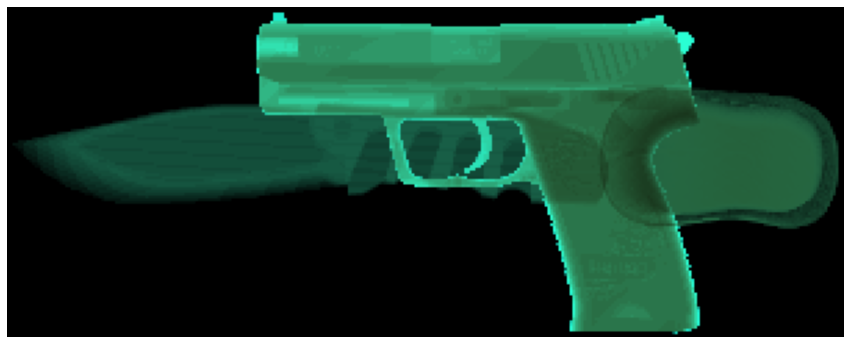

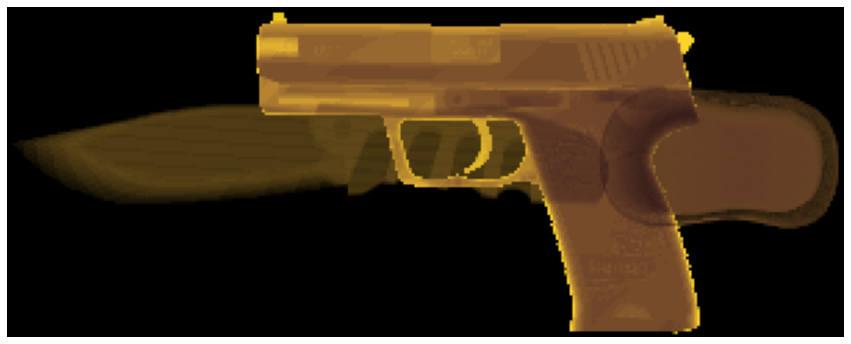

In [33]:
plot_data(img_r); plot_data(img_g); plot_data(img_b)

(array([64004., 13974., 11275.,  7980.,  5440.,  2438.,  1352.,   649.,
          557.,   145.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

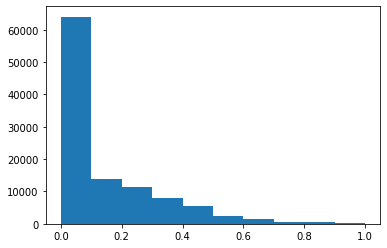

In [34]:
plt.hist(img_r.flatten())

(array([64004., 13974., 11275.,  7980.,  5440.,  2438.,  1352.,   649.,
          557.,   145.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

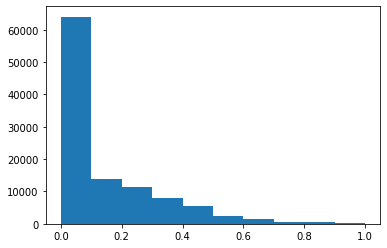

In [35]:
plt.hist(img_g.flatten())

(array([64004., 13974., 11275.,  7980.,  5440.,  2438.,  1352.,   649.,
          557.,   145.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

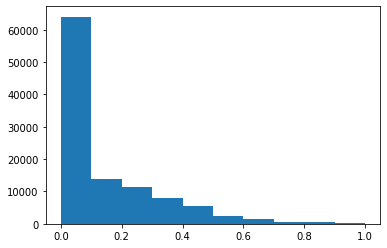

In [36]:
plt.hist(img_b.flatten())

## Assigning different energies in different channels

### Using 2 xrays

Using zeros in the "extra" channel

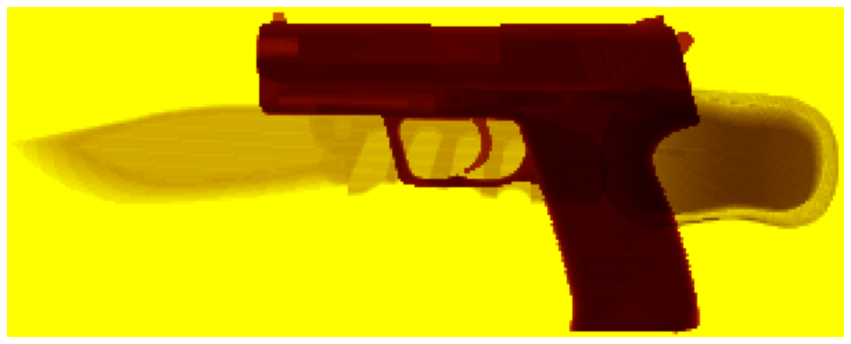

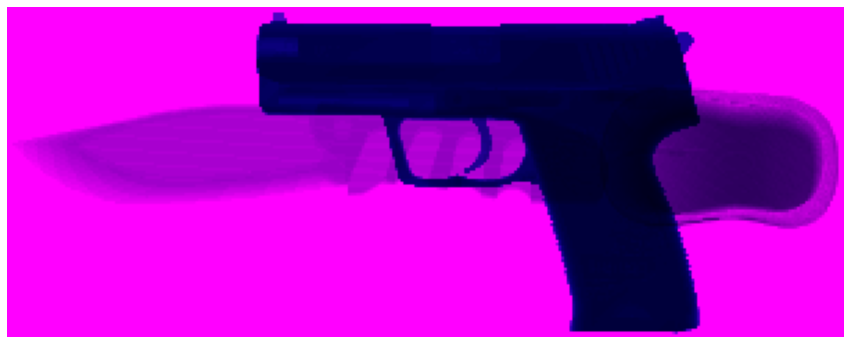

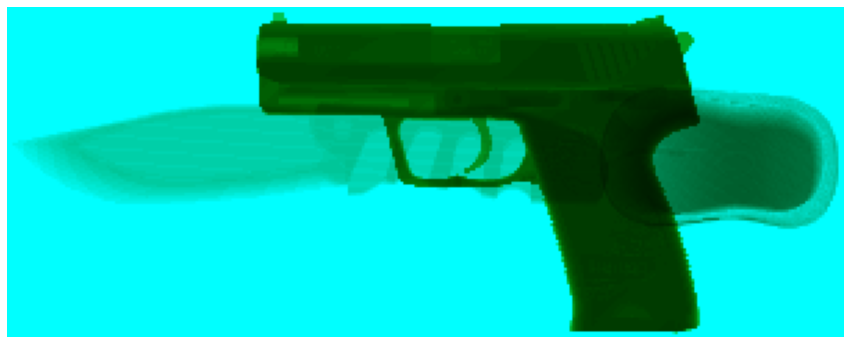

In [37]:
red = he
green = le
blue = np.zeros_like(red)

img_r = np.dstack((red, green, blue))
img_r /= img_r.max()
img_g = np.dstack((green, blue, red))
img_g /= img_g.max()
img_b = np.dstack((blue, red, green))
img_b /= img_b.max()

plot_data(img_r); plot_data(img_g); plot_data(img_b)

Using ones in the "extra" channel

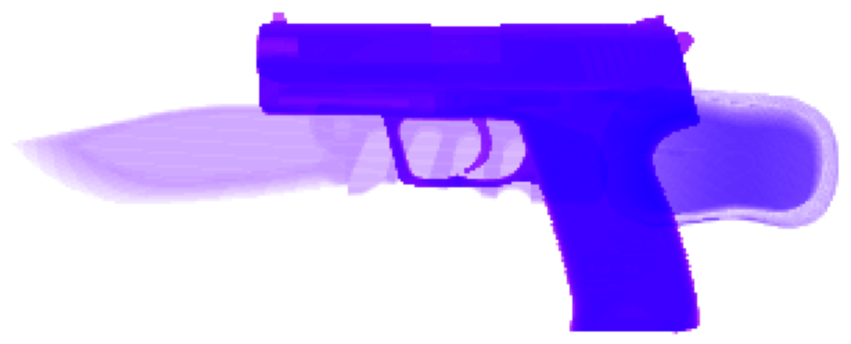

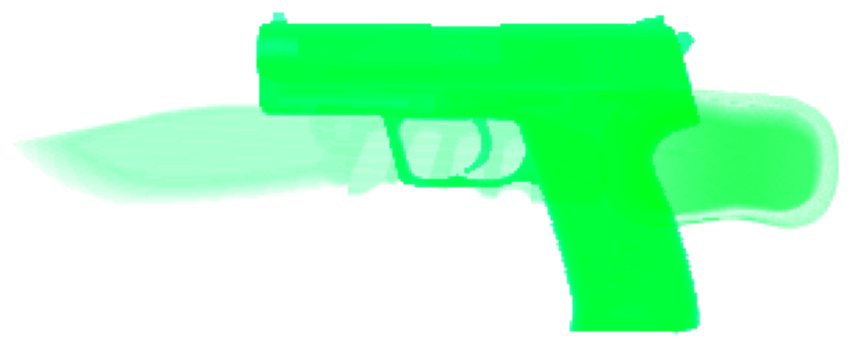

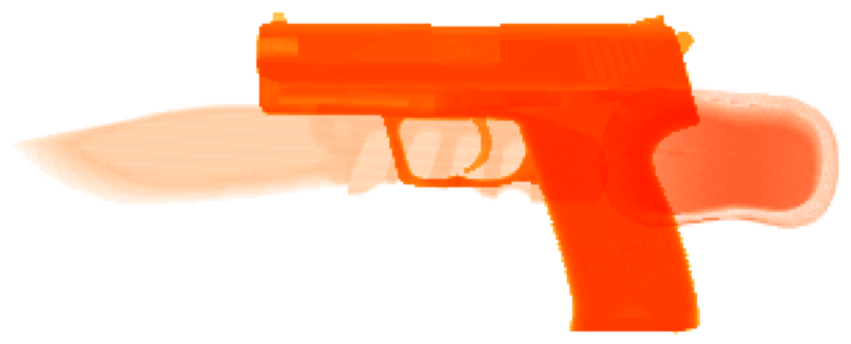

In [38]:
red = he
green = le
blue = np.ones_like(red)

img_r = np.dstack((red, green, blue))
img_r /= img_r.max()
img_g = np.dstack((green, blue, red))
img_g /= img_g.max()
img_b = np.dstack((blue, red, green))
img_b /= img_b.max()

plot_data(img_r); plot_data(img_g); plot_data(img_b)

#### Using 3 xrays

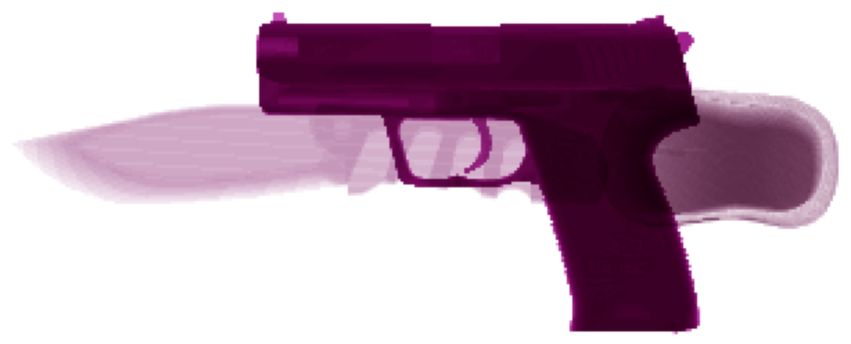

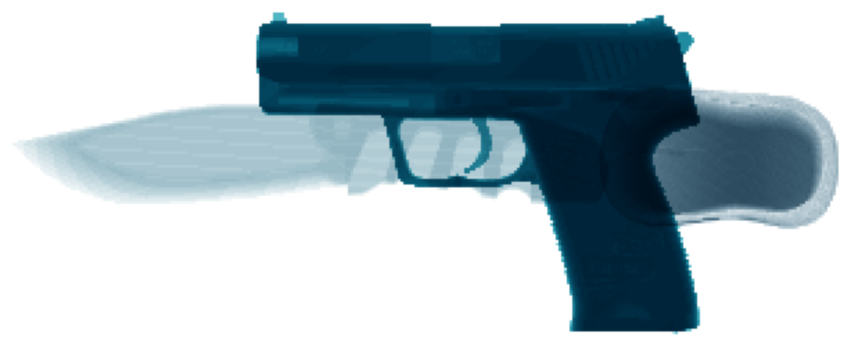

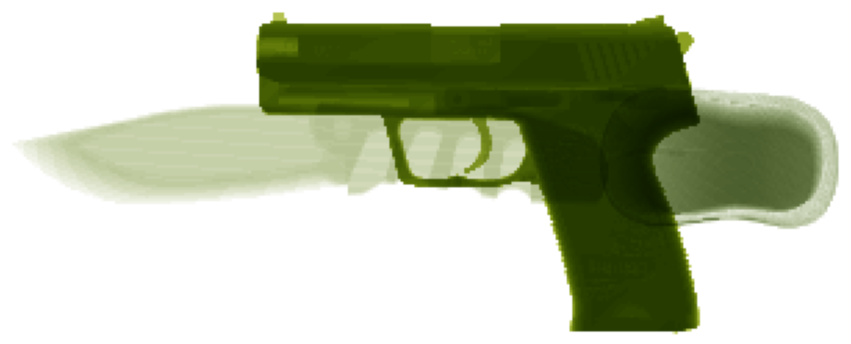

In [39]:
red = he
green = le
blue = me

img_r = np.dstack((red, green, blue))
img_r /= img_r.max()
img_g = np.dstack((green, blue, red))
img_g /= img_g.max()
img_b = np.dstack((blue, red, green))
img_b /= img_b.max()

plot_data(img_r); plot_data(img_g); plot_data(img_b)